# Synthetic expression data from asynchronous random walks

In [1]:
# visualisation
import matplotlib.pyplot as plt
import plotnine as gg
import random

# data io
import numpy as np
import pandas as pd

# generation of unique identifiers for reproducibility
from IPython import get_ipython
ipython = get_ipython()
import datetime as dt

from scboolseq import scBoolSeq
from scboolseq.simulation import (
    biased_simulation_from_binary_state,
    _simulate_subset,
    simulate_gene, 
    simulate_bimodal_gene,
    simulate_unimodal_gene
)
from scboolseq.utils.customobjs import (
    Path, 
    ObjDict as odict
)


# Asynchronous semantics for random walks
from colomoto.minibn import *

# set the project root and create diferent locations
root = Path(".").resolve()
locations = odict({
    "root": root,
    "data": root.joinpath("../data").resolve(),
    "criteriae": root.joinpath("../criteriae").resolve(),
    "synthetic_data": root.joinpath("../synthetic_data/").resolve()
})

# set seed for reproducible results
_rng_seed = 19834650
# use a Generator instead of numpy's singleton
_rng = np.random.default_rng(_rng_seed)

# Visualise the paths
for name, location in locations.items():
    if not location.exists():
        raise FileNotFoundError(f"Specified location \n{location}\n does not exist !")
    #print(f"{name} -> {location}")

## Retrieve statistics of real expression datasets.

In [2]:
criteriae = odict({
    criteria.name.replace("scBoolSeq_Nestorowa_", "").replace(".csv", ""): pd.read_csv(criteria, index_col=0)
    for criteria in locations.criteriae.glob("*csv")
})
criteriae.lkeys

['simulation_criteria']

In [3]:
criteria = criteriae.simulation_criteria
criteria.head()

,Dip,BI,Kurtosis,DropOutRate,MeanNZ,DenPeak,Amplitude,gaussian_prob1,gaussian_prob2,gaussian_mean1,gaussian_mean2,gaussian_variance,mean,variance,unimodal_margin_quantile,unimodal_low_quantile,unimodal_high_quantile,IQR,q50,bim_thresh_down,bim_thresh_up,Category
Clec1b,0.994849,1.635698,6.166711,0.876208,1.520978,-0.007249,8.852181,0.986140,0.013860,0.111291,5.666490,0.157649,1.520978,2.666760,0.25,0.667271,1.555290,0.888020,0.968776,2.785740,3.094168,Unimodal
Mns1,0.000000,2.066577,-1.366120,0.100242,4.743786,1.884848,10.862714,0.607455,0.392545,1.949125,7.857075,1.948831,4.743786,9.166517,0.25,1.994418,7.569707,5.575288,3.798141,4.043072,6.026639,Bimodal
Zfp758,0.000000,2.656696,-1.077530,0.410024,3.392367,0.032378,10.114596,0.802972,0.197028,0.716757,7.236947,0.952938,3.392367,8.305333,0.25,1.103814,6.430069,5.326255,1.911847,3.691636,4.635897,Bimodal
Zfp655,0.000000,2.375439,-1.429402,0.179348,4.114937,0.887514,10.453106,0.653967,0.346033,1.296866,7.308042,1.449121,4.114937,8.699362,0.25,1.419807,7.125837,5.706030,2.970440,3.740356,5.248518,Bimodal
Srxn1,0.001124,2.538884,-0.893849,0.690217,3.146476,0.006911,10.074096,0.895532,0.104468,0.303613,6.727692,0.598964,3.146476,7.578089,0.25,0.962015,5.719712,4.757697,1.682418,3.431388,4.041717,Bimodal


In [4]:
criteria.Category.value_counts()

Bimodal      2922
Unimodal     1645
Discarded     201
Name: Category, dtype: int64

## Creation of minimal boolean networks

In [5]:
bn_spec_dict = {"tf": 1}
bn_spec_dict.update({f"gene{i}": "tf" for i in range(1, 10+1)})
bn = BooleanNetwork(bn_spec_dict)
bn

gene1 <- tf
gene10 <- tf
gene2 <- tf
gene3 <- tf
gene4 <- tf
gene5 <- tf
gene6 <- tf
gene7 <- tf
gene8 <- tf
gene9 <- tf
tf <- 1

# computing graph layout...


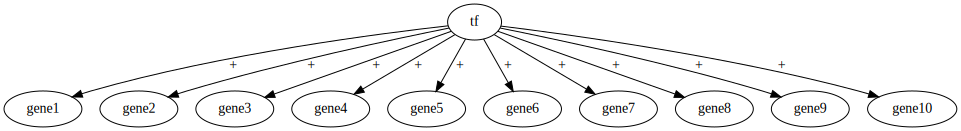

In [6]:
influence_graph = bn.influence_graph()
nx.nx_pydot.write_dot(influence_graph, "star_network.dot")
influence_graph

In [7]:
dynamics = FullyAsynchronousDynamics(bn)
dynamics

In [8]:
initial_state = {gene: 0 for gene in bn_spec_dict.keys()}
initial_state.update({"tf": 1})
initial_state

{'tf': 1,
 'gene1': 0,
 'gene2': 0,
 'gene3': 0,
 'gene4': 0,
 'gene5': 0,
 'gene6': 0,
 'gene7': 0,
 'gene8': 0,
 'gene9': 0,
 'gene10': 0}

In [9]:
def random_walk_to_data_frame(random_walk_generator):
    _rnd_wlks = list(random_walk_generator)
    _rnd_walk_df = pd.concat(
        [pd.DataFrame(walk, index=[i]) for i, walk in enumerate(_rnd_wlks)], 
        axis="rows"
    )
    _rnd_walk_df.index.name = "step"
    return _rnd_walk_df

In [10]:
for i in range(3):
    random_walk_df = random_walk_to_data_frame(dynamics.random_walk(initial_state, steps=10))
    print(random_walk_df[random_walk_df.columns[1:]], end="\n\n")

      gene1  gene2  gene3  gene4  gene5  gene6  gene7  gene8  gene9  gene10
step                                                                       
0         0      0      0      0      0      0      0      0      0       0
1         0      0      0      0      0      0      1      0      0       0
2         1      0      0      0      0      0      1      0      0       0
3         1      0      0      1      0      0      1      0      0       0
4         1      0      0      1      1      0      1      0      0       0
5         1      0      0      1      1      1      1      0      0       0
6         1      1      0      1      1      1      1      0      0       0
7         1      1      0      1      1      1      1      0      1       0
8         1      1      0      1      1      1      1      0      1       1
9         1      1      0      1      1      1      1      1      1       1
10        1      1      1      1      1      1      1      1      1       1

      gene1

In [11]:
for n_line in random_walk_df.iterrows():
    _n, line = n_line
    print(f"line {_n}, has {line.sum()} ones")

line 0, has 1 ones
line 1, has 2 ones
line 2, has 3 ones
line 3, has 4 ones
line 4, has 5 ones
line 5, has 6 ones
line 6, has 7 ones
line 7, has 8 ones
line 8, has 9 ones
line 9, has 10 ones
line 10, has 11 ones


In [12]:
# perform random sampling over bimodal genes
random_criteria = criteria[
    (criteria.Category == "Bimodal") &
    (criteria.DropOutRate < 0.05)
].sample(11, random_state=_rng_seed)
# associate the sampled criteria to the model's nodes
dummy_criteria = random_criteria.copy(deep=True).set_index(random_walk_df.columns)
dummy_criteria

,Dip,BI,Kurtosis,DropOutRate,MeanNZ,DenPeak,Amplitude,gaussian_prob1,gaussian_prob2,gaussian_mean1,gaussian_mean2,gaussian_variance,mean,variance,unimodal_margin_quantile,unimodal_low_quantile,unimodal_high_quantile,IQR,q50,bim_thresh_down,bim_thresh_up,Category
tf,0.000000,2.204589,-1.296402,0.030193,5.937746,8.215683,10.802706,0.384682,0.615318,2.330445,7.901582,1.511589,5.937746,8.074533,0.25,3.048493,8.326143,5.277650,7.024974,4.190001,5.790008,Bimodal
gene1,0.000000,2.140588,-1.304451,0.022343,5.832109,8.004510,10.580911,0.383947,0.616053,2.428006,7.742154,1.457776,5.832109,7.568155,0.25,3.100140,8.126594,5.026454,6.759009,4.149689,5.782134,Bimodal
gene2,0.004504,1.965144,-0.980230,0.015097,6.642170,8.678775,10.986034,0.330903,0.669097,2.941889,8.322288,1.659703,6.642170,7.531391,0.25,4.199070,8.845707,4.646637,7.635968,4.485248,6.325673,Bimodal
gene3,0.000000,2.176400,-1.374235,0.025966,5.554317,7.572444,10.661850,0.411331,0.588669,2.249071,7.618852,1.474003,5.554317,7.885181,0.25,2.675313,7.843694,5.168381,6.493051,4.005325,5.647730,Bimodal
gene4,0.000061,1.879387,-0.486789,0.006643,7.058469,8.157439,11.756951,0.257121,0.742879,3.011898,8.395932,1.567614,7.058469,6.825287,0.25,5.324472,8.902677,3.578205,7.790254,4.527685,6.256280,Bimodal
gene5,0.000000,2.006684,-1.438835,0.039251,4.940110,1.981498,10.756183,0.521854,0.478146,2.281369,7.436358,1.646672,4.940110,7.662534,0.25,2.236204,7.548938,5.312735,4.847397,3.942588,5.833530,Bimodal
gene6,0.008914,1.829326,0.071704,0.004831,7.328485,8.409098,11.552874,0.203062,0.796938,3.112956,8.358191,1.330458,7.328485,5.554741,0.25,6.514508,8.940043,2.425536,8.038056,4.616778,6.158220,Bimodal
gene7,0.000000,2.317892,-0.841413,0.006643,6.735458,8.508093,12.133093,0.294334,0.705666,2.790051,8.317693,1.181227,6.735458,7.280929,0.25,4.148332,8.752579,4.604247,7.884896,4.731106,5.999278,Bimodal
gene8,0.000000,2.031749,-1.390363,0.017512,5.737975,2.909405,12.007258,0.568352,0.431648,3.161875,8.897138,1.954851,5.737975,9.632509,0.25,2.941206,8.722994,5.781788,4.991103,5.107170,7.137512,Bimodal
gene9,0.000000,2.574075,-1.477778,0.032005,5.897388,8.547923,11.345699,0.413554,0.586446,2.054376,8.285580,1.421221,5.897388,10.089566,0.25,2.459253,8.667932,6.208679,7.271125,4.409922,5.786097,Bimodal


In [13]:
scBoolSeq.simulate_with_metadata?

In [14]:
random_walk_df.shape

(11, 11)

In [15]:
scbool = scBoolSeq(simulation_criteria=dummy_criteria)
scbool

scBoolSeq(has_data=False, can_binarize=False, can_simulate=True)

In [26]:
_export_rnd_wlk = random_walk_df.set_index(random_walk_df.index.astype("str"))
_synthetic, _metadata = scbool.simulate_with_metadata(_export_rnd_wlk)

In [24]:
# for all runs to obtain the same results the seeds of each run should be fixed
_simulation_seeds = _rng.integers(123, _rng_seed, size=len(random_walk_df.index))

#sample_sizes = _rng.integers(300, 800, size=len(random_walk_df.index))
sample_sizes = [300] * len(random_walk_df.index)

# generate synthetic samples
synthetic_samples = []
for size, rnd_walk_step, _rng_seed in zip(sample_sizes, random_walk_df.iterrows(), _simulation_seeds):
    _idx, binary_state = rnd_walk_step
    
    synthetic_samples.append(
        biased_simulation_from_binary_state(
            binary_state.to_frame().T, 
            dummy_criteria, 
            n_samples=size,
            seed=_rng_seed
        )
        .reset_index()
        .rename(columns = {"index": "step"})
    )

# merge all experiments into a single frame
synthetic_single_cell_experiment = pd.concat(synthetic_samples, axis="rows", ignore_index=True)
# Correct the step enumeration and tag
synthetic_single_cell_experiment.loc[:, "step"] += 1
synthetic_single_cell_experiment.rename(columns = {"step" : "n_activated_genes"}, inplace=True)
# create an informative, artificial, and unique index
synthetic_single_cell_experiment = synthetic_single_cell_experiment.set_index(
    synthetic_single_cell_experiment.n_activated_genes.apply(lambda x: f"ng{str(x)}") +
    synthetic_single_cell_experiment.index.map(lambda x: f"obs{str(x)}")
)

# Create a colour map for different cell types
number_of_colors = len(synthetic_single_cell_experiment.n_activated_genes.unique())
_RGB_values = list('0123456789ABCDEF')
color_map = {
    i: "#"+''.join([_rng.choice(_RGB_values) for j in range(6)])
    for i in range(1, number_of_colors+1)
}

# Create a metadata frame
cell_colours = (
synthetic_single_cell_experiment
    .n_activated_genes
    .apply(lambda x: color_map[x])
    .to_frame()
    .rename(columns = {"n_activated_genes": "label_color"})
)
metadata = pd.concat([synthetic_single_cell_experiment.n_activated_genes, cell_colours], axis="columns")
metadata = metadata.rename(columns = {"n_activated_genes": "label"})
# drop the number of activated genes from the synthetic expression frame
synthetic_single_cell_experiment = synthetic_single_cell_experiment[synthetic_single_cell_experiment.columns[1:]]

In [25]:
synthetic_single_cell_experiment.head()

,tf,gene1,gene2,gene3,gene4,gene5,gene6,gene7,gene8,gene9,gene10
ng1obs0,6.346190,1.791609,1.033226,0.586312,1.592745,1.142321,3.891361,4.226309,3.064126,2.092487,1.606416
ng1obs1,9.581022,0.000000,3.147905,1.122426,2.019056,1.769516,1.995043,3.006294,2.650973,1.096767,3.779568
ng1obs2,10.245059,2.054394,1.362059,3.625287,4.271432,2.172515,1.874709,3.824866,4.454092,1.863294,1.466044
ng1obs3,8.582333,2.315483,3.164752,2.891717,4.471223,3.719249,3.329098,4.539091,3.056076,1.246343,2.781652
ng1obs4,8.700413,4.156005,2.829063,2.174785,1.542663,1.452257,4.585366,3.385134,3.452260,0.569067,0.780699


In [ ]:
metadata.head()

In [ ]:
synthetic_export = synthetic_single_cell_experiment.T

In [ ]:
# Create a unique identifier so that any experiment can be traced back and reproduced
_unique_spec = f"core_nw1_date-{str(dt.datetime.now()).split(' ')[0]}_seed-{_rng_seed}_ecount-{ipython.execution_count}"
random_walk_df.to_csv(
    locations.synthetic_data.joinpath(f"{_unique_spec}_boolean.tsv"), sep="\t"
)
synthetic_export.to_csv(
    locations.synthetic_data.joinpath(f"{_unique_spec}_synthetic.tsv"), sep="\t"
)
metadata.to_csv(
    locations.synthetic_data.joinpath(f"{_unique_spec}_metadata.tsv"), sep="\t"
)